<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Basic-image-statistics" data-toc-modified-id="Basic-image-statistics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Basic image statistics</a></span><ul class="toc-item"><li><span><a href="#Weighted-averages" data-toc-modified-id="Weighted-averages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Weighted averages</a></span></li><li><span><a href="#Verify-with-random-numbers" data-toc-modified-id="Verify-with-random-numbers-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Verify with random numbers</a></span></li><li><span><a href="#Example:-far-infrared-images" data-toc-modified-id="Example:-far-infrared-images-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Example: far-infrared images</a></span></li></ul></li></ul></div>

# Basic image statistics

This notebook shows some basic tools for interpreting telescope images of distant galaxies, taking the example of the distant galaxy GNz11 in the "GOODS-North" survey field from the Hubble Space telescope [(Oesch et al. 2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...819..129O/abstract).

In [1]:
!pip install scikit-image

In [30]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.interpolation'] = 'Nearest'
plt.rcParams['image.origin'] = 'lower'

import scipy.stats

## Weighted averages

We'll use a simple technique throughout to compute weighted averages of quantities where we have (1D, 2D) arrays of noisy measurements and corresponding arrays of the uncertainties estimated from knowledge of the detector characteristics.  

For convenience, we'll frequently define inverse variance weight arrays

$\mathrm{w} = 1/\sigma^2$, 

so that dividing by $\sigma^2$ is rather a multiplicative operation (and where missing data is naturally described by $\mathrm{w} = 0$.

For data $x_i$ with weights $w_i = 1 / \sigma_i^2$, the weighted average of $x$ is

$\bar x = \sum(x_i w_i) / \sum(w_i)$. 

with variance

$s^2 = 1 / \sum(w_i)$.

## Verify with random numbers

In [31]:
Ndraws = 10000
Ntrials = 1000

xbar = np.zeros(Ntrials)
s2 = np.zeros(Ntrials)

for i in range(Ntrials):
    # Unequal uncertainties
    sig = np.random.rand(Ndraws)+1
    rvs = np.random.normal(size=Ndraws)*sig
    w = 1/sig**2
    xbar[i] = (rvs*w).sum()/w.sum()
    s2[i] = 1/w.sum()
    

AndersonResult(statistic=0.20274729418576953, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

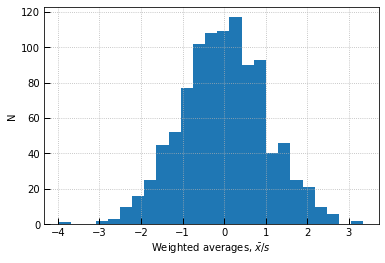

In [34]:
# Are the computed averages normally distributed given 
# their calculated variances?
_h = plt.hist(xbar/np.sqrt(s2), bins=25)
plt.grid()
plt.xlabel(r'Weighted averages, $\bar{x}/s$')
plt.ylabel('N')

scipy.stats.anderson(xbar/np.sqrt(s2))

## Example: far-infrared images

The field around GN-z11 was observed with the Scuba2 instrument on the James Clerk Maxwell telescope at a wavelength of 850 µm.  The background at these wavelengths is generally **much** brighter than the sources of interest, so many exposures are taken and averaged to make the final map.

In [45]:
# Image data
scuba2 = np.load('scuba2.npy', allow_pickle=True)[0]
print('Keys: ', scuba2.keys())
for k in scuba2:
    print(k, scuba2[k].shape)
    
Nexp, ydim, xdim = scuba2['intensity'].shape

Keys:  dict_keys(['intensity', 'weight', 'exposure_time'])
intensity (275, 72, 72)
weight (275, 72, 72)
exposure_time (275,)


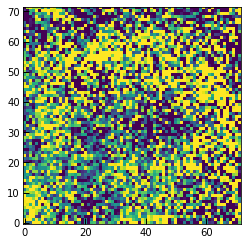

In [46]:
# Show the first exposure
plt.imshow(scuba2['intensity'][0,:,:], vmin=-10, vmax=10)

In [47]:
# Cumulative weighted average
cumul_num = np.cumsum(scuba2['intensity']*scuba2['weight'], axis=0)
cumul_den = np.cumsum(scuba2['weight'], axis=0)

cumul_intensity = cumul_num/cumul_den
cumul_var = 1/cumul_den

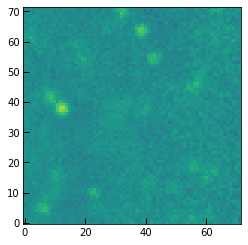

In [48]:
# Show the final weighted image
plt.imshow(cumul_intensity[-1,:,:], vmin=-10, vmax=10)

In [49]:
# How does the median weight (1/s^2) of the weighted stack 
# change with time?
cumul_weight = 1/cumul_var # = cumul_den = sum of weights

median_wht = [np.median(cumul_weight[i,:,:]) for i in range(Nexp)]

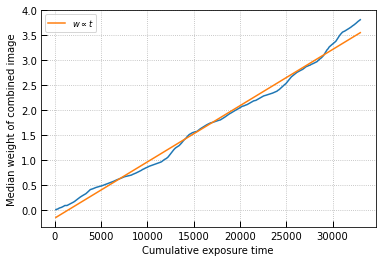

In [55]:
# Fit with a line (weight linear in time is 1/sqrt(s) time as expected
cumul_time = np.cumsum(scuba2['exposure_time'])

plt.plot(cumul_time, median_wht)

_c = np.polyfit(cumul_time, median_wht, 1)
plt.plot(cumul_time, np.polyval(_c, cumul_time), label=r'$w\propto t$')
plt.xlabel('Cumulative exposure time')

plt.ylabel('Median weight of combined image')

plt.legend()
plt.grid()

